In [18]:
from collections import defaultdict, Counter
import pandas as pd
from bert_score import score as bert_score
from nlgeval import NLGEval
import seaborn as sns
from matplotlib import pyplot as plt
from nltk import ngrams

In [2]:
_df = pd.concat([
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_appliances.csv', error_bad_lines=False, warn_bad_lines=True),
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_food.csv', error_bad_lines=False, warn_bad_lines=True),
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_indoor.csv', error_bad_lines=False, warn_bad_lines=True),
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_outdoor.csv', error_bad_lines=False, warn_bad_lines=True),
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_vehicles.csv', error_bad_lines=False, warn_bad_lines=True)
])

# pd.to_numeric(df['target domain'], errors='coerce')

print('target domain   :', _df['target domain'].unique())
print('listener domain :', _df['listener domain'].unique())
print('simulator domain:', _df['interpreter domain'].unique())
_df = _df.dropna()
print('Data points:', len(_df))

id_df = _df[(_df['target domain'] == _df['listener domain'])]
ood_df = _df[(_df['target domain'] != _df['listener domain'])]

df = ood_df
df.head(2)


/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_16603/3144538958.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_appliances.csv', error_bad_lines=False, warn_bad_lines=True),
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_16603/3144538958.py:2: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_appliances.csv', error_bad_lines=False, warn_bad_lines=True),
b'Skipping line 1397: expected 198 fields, saw 443\n'
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_16603/3144538958.py:2: DtypeWarning: Columns (54,55,56,64,65,66) have mixed types. Specify dtype option on imp

target domain   : ['food' 'vehicles' 'outdoor' 'indoor' 'appliances']
listener domain : ['indoor' 'appliances' 'food' 'outdoor' 'vehicles']
simulator domain: ['indoor' 'appliances' 'food' 'outdoor' 'vehicles']
Data points: 5817


,Unnamed: 0,target domain,listener domain,interpreter domain,target img idx,img path #0,img path #1,img path #2,img path #3,img path #4,...,int_list_acc10,int_list_acc11,int_list_acc12,int_list_acc13,int_list_acc14,int_list_acc15,int_list_acc16,int_list_acc17,int_list_acc18,int_list_acc19
2,2,food,indoor,indoor,0,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,food,indoor,indoor,2,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
N_STEPS = 20

refs = df['golden utt'].tolist()
refs_for_nlgeval = [[ref] for ref in refs]

hyps = {"h0": df['original utt'].tolist()}
hyps.update(
    {f"h0 {s}": df[f"adapted utt s{s}"].tolist() for s in range(N_STEPS)}
)
hyps.keys()

dict_keys(['h0', 'h0 0', 'h0 1', 'h0 2', 'h0 3', 'h0 4', 'h0 5', 'h0 6', 'h0 7', 'h0 8', 'h0 9', 'h0 10', 'h0 11', 'h0 12', 'h0 13', 'h0 14', 'h0 15', 'h0 16', 'h0 17', 'h0 18', 'h0 19'])

## Classic NLG metrics

In [ ]:
nlgeval = NLGEval(no_skipthoughts=True, no_glove=True, metrics_to_omit=['METEOR'])

score_dicts = []
for hyp_type in hyps:
    metrics_dict = nlgeval.compute_metrics(refs_for_nlgeval, hyps[hyp_type])
    (P, R, F)= bert_score(
        hyps[hyp_type],
        refs,
        lang="en",
        return_hash=False,
        model_type="microsoft/deberta-xlarge-mnli",
    )
    metrics_dict['BERT_P'] = P.mean().item()
    metrics_dict['BERT_R'] = R.mean().item()
    metrics_dict['BERT_F'] = F.mean().item()
    score_dicts.append(metrics_dict)

score_df = pd.DataFrame(score_dicts, index=hyps.keys())

Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['classifier.weight', 'classifier.bias', 'pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['classifier.weight', 'classifier.bias', 'pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture

In [ ]:
axes = score_df.plot.bar(rot=0, subplots=True, figsize=(20,20), legend=None)
# axes[1].legend()

## Utterance length

In [4]:
lengths = defaultdict(list)

for ref in refs:
    lengths['ref'].append(len(ref.strip().split()))

for hyp_type in hyps:
    for hyp in hyps[hyp_type]:
        lengths[hyp_type].append(len(hyp.strip().split()))

len_df = pd.DataFrame(lengths.values(), index=lengths.keys()).T


Text(0.5, 1.0, 'Utterance length')

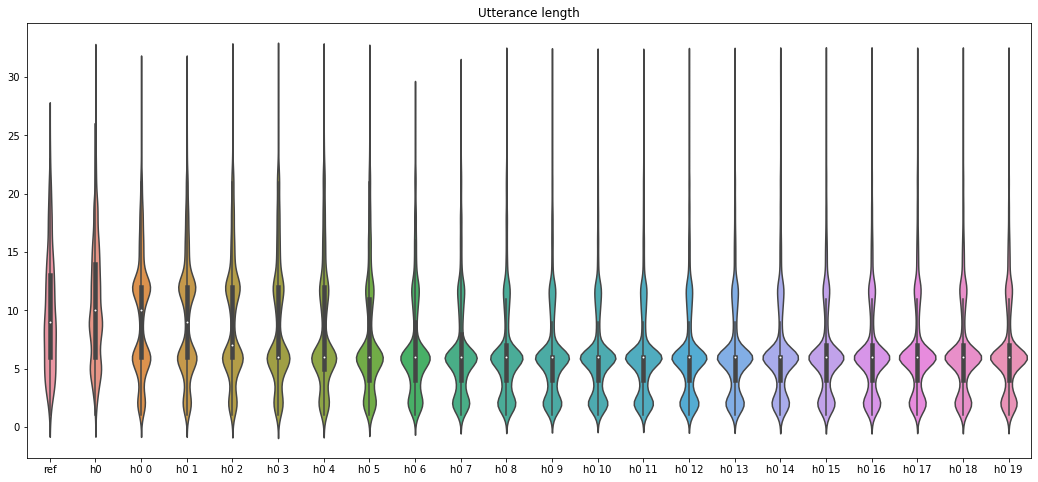

In [48]:
plt.rcParams["figure.figsize"] = (18,8)
sns.violinplot(data=len_df)
plt.title('Utterance length')

## Repetitions

In [24]:
def ngram_reps(text, n=1):
    token_seq = text.strip().split()
    ngram_seq = list(ngrams(token_seq, n))
    if len(ngram_seq) <= 1:
        return 0.

    ngram_counter = Counter(ngram_seq)
    n_repeated_tokens = 0
    n_repeated_types = 0
    for w in ngram_counter:
        if ngram_counter[w] > 1:
            n_repeated_tokens += ngram_counter[w]
            n_repeated_types += 1

    return (n_repeated_tokens - n_repeated_types) / len(ngram_seq)


In [25]:
reps = defaultdict(lambda: defaultdict(list))

for N in range(1, 4):
    for ref in refs:
        reps[N]['ref'].append(ngram_reps(ref, n=N))

    for hyp_type in hyps:
        for hyp in hyps[hyp_type]:
            reps[N][hyp_type].append(ngram_reps(hyp, n=N))

rep_df_1 = pd.DataFrame(reps[1].values(), index=reps[1].keys()).T
rep_df_2 = pd.DataFrame(reps[2].values(), index=reps[2].keys()).T
rep_df_3 = pd.DataFrame(reps[3].values(), index=reps[3].keys()).T

Text(0.5, 1.0, 'Unigram repetitions (percentage repeated tokens)')

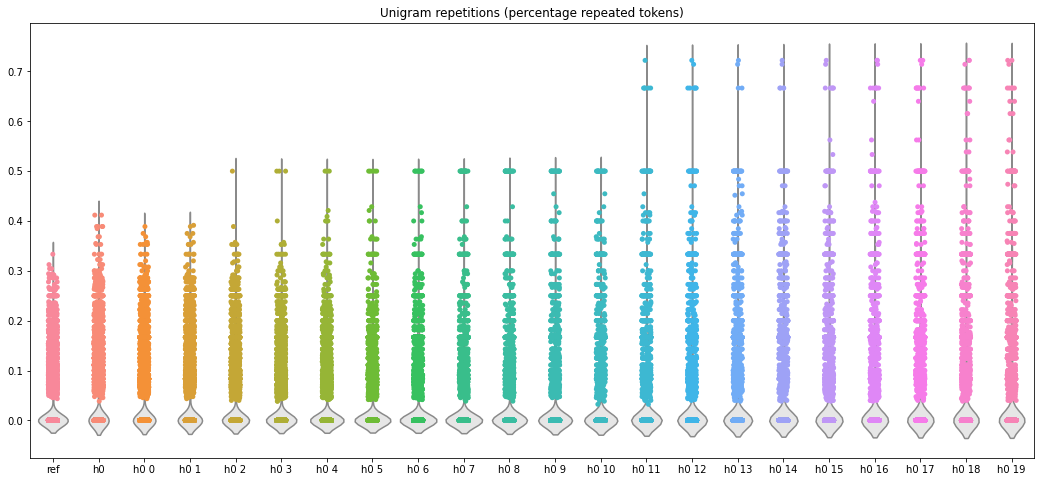

In [49]:
sns.violinplot(data=rep_df_1, inner=None, color=".9")
sns.stripplot(data=rep_df_1)
plt.title('Unigram repetitions (percentage repeated tokens)')

<AxesSubplot:>

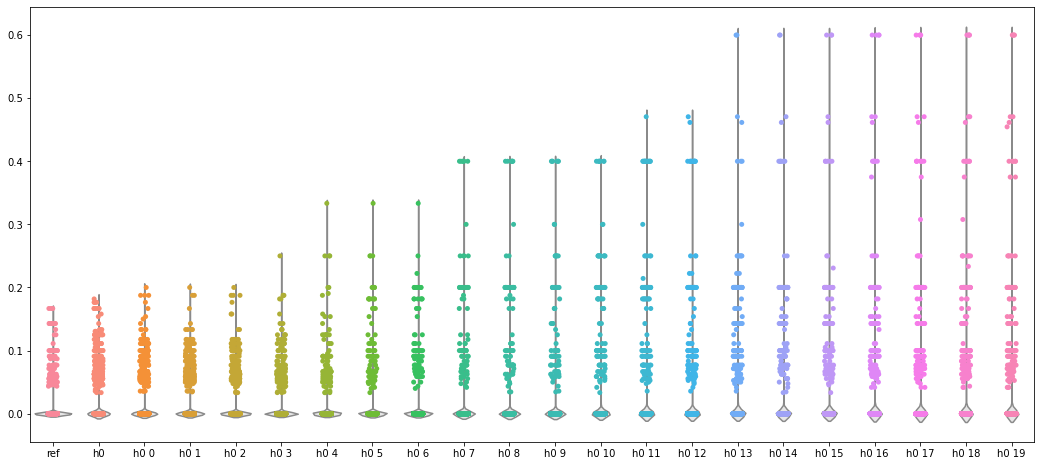

In [38]:
sns.violinplot(data=rep_df_2, inner=None, color=".9")
sns.stripplot(data=rep_df_2)

<AxesSubplot:>

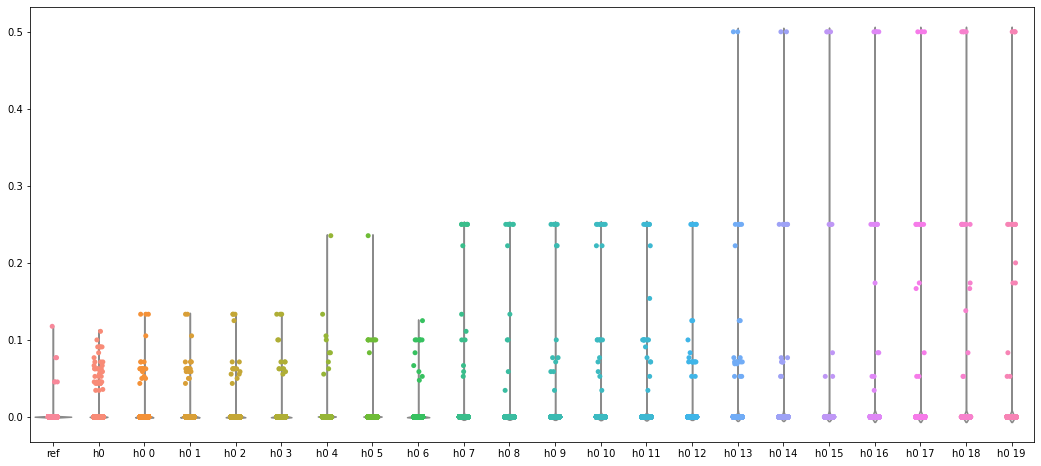

In [40]:
sns.violinplot(data=rep_df_3, inner=None, color=".9")
sns.stripplot(data=rep_df_3)